In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
import sys
import os

# Adds the parent directory (..) to the system path
sys.path.append(os.path.abspath(os.path.join('..')))

# Now your import will work
from greenwashing_analyzer import GreenwashingAnalyzer
import warnings
warnings.filterwarnings('ignore')

# Helper Functions

In [16]:
def load_and_prepare_data(csv_path, label_column='greenwashing', text_column='combined_text', filter_labels=True):
    """
    Load and optionally clean dataset.
    
    Args:
        csv_path: Path to CSV file
        label_column: Name of the ground truth label column
        text_column: Name of the text input column
        filter_labels: If True, filter out 'error' and 'uncertain' labels
    
    Returns:
        Cleaned DataFrame
    """
    print(f"Loading data from {csv_path}...")
    df = pd.read_csv(csv_path)
    
    if filter_labels:
        df_clean = df[df[label_column].isin(['greenwashing', 'not_greenwashing'])].copy()
        print(f"Total samples: {len(df)}")
        print(f"Clean samples (excluding errors/uncertain): {len(df_clean)}")
    else:
        df_clean = df.copy()
        print(f"Total samples: {len(df)}")
    
    print(f"\nLabel distribution:")
    print(df_clean[label_column].value_counts())
    
    return df_clean

In [17]:
def score_to_label(scores, threshold, positive_label='greenwashing'):
    """
    Convert continuous scores into labels using a threshold.
    """
    return np.where(scores >= threshold, positive_label, 'not_greenwashing')


In [18]:
def run_predictions(
    df,
    analyzer,
    text_column='combined_text',
    risk_threshold=0.5,
    specificity_threshold=0.5
):
    """
    Run composite vs specificity-only predictions correctly.
    Labels are derived from their own scores.
    """

    print("\n" + "="*70)
    print("Running predictions...")
    print("="*70)

    risk_scores = []
    specificity_scores = []

    for idx, row in df.iterrows():
        text = row[text_column]

        # Composite (3-module)
        composite = analyzer.analyze_additive(text)
        risk_scores.append(composite['risk_score'])

        # Specificity-only
        spec = analyzer.analyze_specificity_only(text)
        specificity_scores.append(spec['specificity_score'])

        if (idx + 1) % 20 == 0:
            print(f"Processed {idx + 1}/{len(df)} samples...")

    df['risk_score'] = risk_scores
    df['specificity_score'] = specificity_scores

    # 🔑 DERIVE LABELS FROM THEIR OWN SCORES
    df['pred_composite'] = score_to_label(df['risk_score'], risk_threshold)
    df['pred_specificity_only'] = score_to_label(df['specificity_score'], specificity_threshold)

    print("✓ Predictions complete!")

    return df


In [19]:
def calculate_metrics(y_true, y_pred, method_name):
    """
    Calculate all classification metrics.
    
    Args:
        y_true: Ground truth labels
        y_pred: Predicted labels
        method_name: Name of the method for display
    
    Returns:
        Dictionary of metrics
    """
    # Convert labels to binary (1 = greenwashing, 0 = not_greenwashing)
    y_true_binary = (y_true == 'greenwashing').astype(int)
    y_pred_binary = (y_pred == 'greenwashing').astype(int)
    
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
    
    cm = confusion_matrix(y_true_binary, y_pred_binary)
    
    print(f"\n{'='*70}")
    print(f"{method_name.upper()} - METRICS")
    print(f"{'='*70}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"                 Predicted")
    print(f"                 Not GW    GW")
    print(f"Actual Not GW    {cm[0,0]:6d}  {cm[0,1]:6d}")
    print(f"Actual GW        {cm[1,0]:6d}  {cm[1,1]:6d}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'y_true_binary': y_true_binary,
        'y_pred_binary': y_pred_binary
    }
    

In [20]:
def evaluate_both_methods(df, label_column='greenwashing'):
    """
    Calculate metrics for both methods.
    
    Args:
        df: DataFrame with predictions
        label_column: Name of the ground truth label column
    
    Returns:
        Tuple of (metrics_composite, metrics_specificity)
    """
    y_true = df[label_column]
    
    metrics_composite = calculate_metrics(
        y_true, 
        df['pred_composite'], 
        "Composite Method (analyze)"
    )
    
    metrics_specificity = calculate_metrics(
        y_true, 
        df['pred_specificity_only'], 
        "Specificity-Only Method"
    )
    
    return metrics_composite, metrics_specificity


In [21]:
def print_comparison_table(metrics_composite, metrics_specificity):
    """
    Print comparison table of both methods.
    
    Args:
        metrics_composite: Metrics dictionary for composite method
        metrics_specificity: Metrics dictionary for specificity-only method
    
    Returns:
        Comparison DataFrame
    """
    print(f"\n{'='*70}")
    print("COMPARISON SUMMARY")
    print(f"{'='*70}")
    
    comparison_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
        'Composite (analyze)': [
            metrics_composite['accuracy'],
            metrics_composite['precision'],
            metrics_composite['recall'],
            metrics_composite['f1']
        ],
        'Specificity-Only': [
            metrics_specificity['accuracy'],
            metrics_specificity['precision'],
            metrics_specificity['recall'],
            metrics_specificity['f1']
        ]
    })
    
    comparison_df['Difference'] = comparison_df['Composite (analyze)'] - comparison_df['Specificity-Only']
    comparison_df['Better Method'] = comparison_df['Difference'].apply(
        lambda x: 'Composite' if x > 0.01 else ('Specificity' if x < -0.01 else 'Similar')
    )
    
    print(comparison_df.to_string(index=False))
    
    return comparison_df

In [22]:
def plot_evaluation_results(df, metrics_composite, metrics_specificity, 
                            save_path='evaluation.png', dataset_name='Dataset',
                            label_column='greenwashing'):
    """
    Create comprehensive visualization comparing both methods.
    
    Args:
        df: DataFrame with predictions and scores
        metrics_composite: Metrics dictionary for composite method
        metrics_specificity: Metrics dictionary for specificity-only method
        save_path: Path to save the plot
        dataset_name: Name of dataset for plot title
        label_column: Name of the ground truth label column
    
    Returns:
        Tuple of (roc_auc_comp, roc_auc_spec, ap_comp, ap_spec)
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Greenwashing Detection: {dataset_name}\nComposite vs Specificity-Only Analysis', 
                 fontsize=16, fontweight='bold')
    
    # --- Row 1: Confusion Matrices ---
    for idx, (metrics, title) in enumerate([
        (metrics_composite, 'Composite Method'),
        (metrics_specificity, 'Specificity-Only Method')
    ]):
        cm = metrics['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, idx],
                    xticklabels=['Not GW', 'GW'],
                    yticklabels=['Not GW', 'GW'])
        axes[0, idx].set_title(f'{title}\nConfusion Matrix')
        axes[0, idx].set_ylabel('Actual')
        axes[0, idx].set_xlabel('Predicted')
    
    # Metrics comparison bar chart
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    x = np.arange(len(metrics_names))
    width = 0.35
    
    composite_scores = [
        metrics_composite['accuracy'], 
        metrics_composite['precision'],
        metrics_composite['recall'], 
        metrics_composite['f1']
    ]
    specificity_scores_list = [
        metrics_specificity['accuracy'], 
        metrics_specificity['precision'],
        metrics_specificity['recall'], 
        metrics_specificity['f1']
    ]
    
    axes[0, 2].bar(x - width/2, composite_scores, width, label='Composite', alpha=0.8)
    axes[0, 2].bar(x + width/2, specificity_scores_list, width, label='Specificity-Only', alpha=0.8)
    axes[0, 2].set_ylabel('Score')
    axes[0, 2].set_title('Metrics Comparison')
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels(metrics_names, rotation=45)
    axes[0, 2].legend()
    axes[0, 2].set_ylim(0, 1)
    axes[0, 2].grid(axis='y', alpha=0.3)
    
    # --- Row 2: ROC Curves, PR Curves, Score Distributions ---
    
    # ROC Curve
    fpr_comp, tpr_comp, _ = roc_curve(
        metrics_composite['y_true_binary'], 
        df['risk_score']
    )
    roc_auc_comp = auc(fpr_comp, tpr_comp)
    
    fpr_spec, tpr_spec, _ = roc_curve(
        metrics_specificity['y_true_binary'], 
        df['specificity_score']
    )
    roc_auc_spec = auc(fpr_spec, tpr_spec)
    
    axes[1, 0].plot(fpr_comp, tpr_comp, label=f'Composite (AUC = {roc_auc_comp:.3f})', linewidth=2)
    axes[1, 0].plot(fpr_spec, tpr_spec, label=f'Specificity-Only (AUC = {roc_auc_spec:.3f})', linewidth=2)
    axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random')
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].set_title('ROC Curves')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Precision-Recall Curve
    precision_comp, recall_comp, _ = precision_recall_curve(
        metrics_composite['y_true_binary'], 
        df['risk_score']
    )
    ap_comp = average_precision_score(
        metrics_composite['y_true_binary'], 
        df['risk_score']
    )
    
    precision_spec, recall_spec, _ = precision_recall_curve(
        metrics_specificity['y_true_binary'], 
        df['specificity_score']
    )
    ap_spec = average_precision_score(
        metrics_specificity['y_true_binary'], 
        df['specificity_score']
    )
    
    axes[1, 1].plot(recall_comp, precision_comp, label=f'Composite (AP = {ap_comp:.3f})', linewidth=2)
    axes[1, 1].plot(recall_spec, precision_spec, label=f'Specificity-Only (AP = {ap_spec:.3f})', linewidth=2)
    axes[1, 1].set_xlabel('Recall')
    axes[1, 1].set_ylabel('Precision')
    axes[1, 1].set_title('Precision-Recall Curves')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    # Score distributions
    axes[1, 2].hist(
        df[df[label_column] == 'greenwashing']['risk_score'], 
        bins=20, alpha=0.5, label='Composite (GW)', color='red'
    )
    axes[1, 2].hist(
        df[df[label_column] == 'not_greenwashing']['risk_score'], 
        bins=20, alpha=0.5, label='Composite (Not GW)', color='blue'
    )
    axes[1, 2].axvline(0.4, color='red', linestyle='--', label='Threshold (0.4)')
    axes[1, 2].set_xlabel('Risk Score')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title('Risk Score Distribution (Composite)')
    axes[1, 2].legend()
    axes[1, 2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Visualization saved as '{save_path}'")
    
    return roc_auc_comp, roc_auc_spec, ap_comp, ap_spec

In [23]:
def print_additional_insights(df, roc_auc_comp, roc_auc_spec, ap_comp, ap_spec, 
                             label_column='greenwashing'):
    """
    Print additional insights about the comparison.
    
    Args:
        df: DataFrame with predictions
        roc_auc_comp: ROC AUC for composite method
        roc_auc_spec: ROC AUC for specificity-only method
        ap_comp: Average precision for composite method
        ap_spec: Average precision for specificity-only method
        label_column: Name of the ground truth label column
    """
    print(f"\n{'='*70}")
    print("ADDITIONAL INSIGHTS")
    print(f"{'='*70}")
    
    # Where do the methods disagree?
    disagreement = df[df['pred_composite'] != df['pred_specificity_only']]
    total = len(df)
    print(f"\nDisagreement cases: {len(disagreement)} out of {total} ({len(disagreement)/total*100:.1f}%)")
    
    if len(disagreement) > 0:
        print("\nDisagreement breakdown:")
        print(disagreement.groupby([
            'pred_composite', 
            'pred_specificity_only', 
            label_column
        ]).size())
    
    # ROC AUC comparison
    print(f"\nROC AUC Scores:")
    print(f"  Composite:        {roc_auc_comp:.4f}")
    print(f"  Specificity-Only: {roc_auc_spec:.4f}")
    print(f"  Difference:       {roc_auc_comp - roc_auc_spec:+.4f}")
    
    print(f"\nAverage Precision Scores:")
    print(f"  Composite:        {ap_comp:.4f}")
    print(f"  Specificity-Only: {ap_spec:.4f}")
    print(f"  Difference:       {ap_comp - ap_spec:+.4f}")


In [24]:
def save_results(df, output_path='../data/benchmark/evaluation_results.csv'):
    """
    Save detailed results to CSV.
    
    Args:
        df: DataFrame with all predictions and scores
        output_path: Path to save the CSV
    """
    df.to_csv(output_path, index=False)
    print(f"\n✓ Detailed results saved to '{output_path}'")

In [25]:
def save_prompt_confusion_matrix(metrics_comp, metrics_spec, dataset_name, output_dir="../image/comparison/"):
    """
    Saves a specific plot of confusion matrices for a prompt type to the specified directory.
    """
    # 1. Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # 2. Sanitize filename (e.g., "Zero-Shot Dataset" -> "zero-shot")
    clean_name = dataset_name.lower().replace(" dataset", "").replace(" ", "-").replace("_", "-")
    save_path = os.path.join(output_dir, f"{clean_name}_cm.png")

    # 3. Create the plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"Confusion Matrix Comparison: {dataset_name}", fontsize=14, fontweight='bold')

    # Composite CM
    sns.heatmap(metrics_comp['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Not GW', 'GW'], yticklabels=['Not GW', 'GW'])
    axes[0].set_title('Composite Method')
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')

    # Specificity-Only CM
    sns.heatmap(metrics_spec['confusion_matrix'], annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=['Not GW', 'GW'], yticklabels=['Not GW', 'GW'])
    axes[1].set_title('Specificity-Only Method')
    axes[1].set_ylabel('Actual')
    axes[1].set_xlabel('Predicted')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # 4. Save and close
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"✓ Specific confusion matrix saved to: {save_path}")

In [26]:
def run_full_evaluation(csv_path, analyzer, output_prefix='evaluation',
                       dataset_name='Dataset', label_column='greenwashing',
                       text_column='combined_text', filter_labels=True):
    """
    Updated pipeline to include specialized image saving.
    """
    # 1. Load data
    df = load_and_prepare_data(csv_path, label_column, text_column, filter_labels)

    # 2. Run predictions
    df = run_predictions(df, analyzer, text_column)

    # 3. Calculate metrics
    metrics_comp, metrics_spec = evaluate_both_methods(df, label_column)

    # 4. Print comparison
    comparison_df = print_comparison_table(metrics_comp, metrics_spec)

    # 5. Plot results (Original Dashboard)
    roc_auc_comp, roc_auc_spec, ap_comp, ap_spec = plot_evaluation_results(
        df, metrics_comp, metrics_spec,
        save_path=f'{output_prefix}_full_evaluation.png',
        dataset_name=dataset_name,
        label_column=label_column
    )

    # 6. NEW: Save prompt-specific confusion matrices to ../image/prompt/
    save_prompt_confusion_matrix(metrics_comp, metrics_spec, dataset_name)

    # 7. Print insights
    print_additional_insights(df, roc_auc_comp, roc_auc_spec, ap_comp, ap_spec, label_column)

    # 8. Save results
    save_results(df, output_path=f'{output_prefix}_results.csv')

    return {
        'dataframe': df,
        'comparison_df': comparison_df,
        'metrics_composite': metrics_comp,
        'metrics_specificity': metrics_spec,
        'roc_auc': {'composite': roc_auc_comp, 'specificity': roc_auc_spec},
        'avg_precision': {'composite': ap_comp, 'specificity': ap_spec}
    }


# Run the comparison

Device set to use cpu


Loading data from ../data/benchmark/greenwashing_zero_shot.csv...
Total samples: 100
Clean samples (excluding errors/uncertain): 100

Label distribution:
greenwashing
greenwashing        64
not_greenwashing    36
Name: count, dtype: int64

Running predictions...
Processed 20/100 samples...
Processed 40/100 samples...
Processed 60/100 samples...
Processed 80/100 samples...
Processed 100/100 samples...
✓ Predictions complete!

COMPOSITE METHOD (ANALYZE) - METRICS
Accuracy:  0.6000
Precision: 0.6667
Recall:    0.7500
F1-Score:  0.7059

Confusion Matrix:
                 Predicted
                 Not GW    GW
Actual Not GW        12      24
Actual GW            16      48

SPECIFICITY-ONLY METHOD - METRICS
Accuracy:  0.5700
Precision: 0.6667
Recall:    0.6562
F1-Score:  0.6614

Confusion Matrix:
                 Predicted
                 Not GW    GW
Actual Not GW        15      21
Actual GW            22      42

COMPARISON SUMMARY
   Metric  Composite (analyze)  Specificity-Only  Diffe

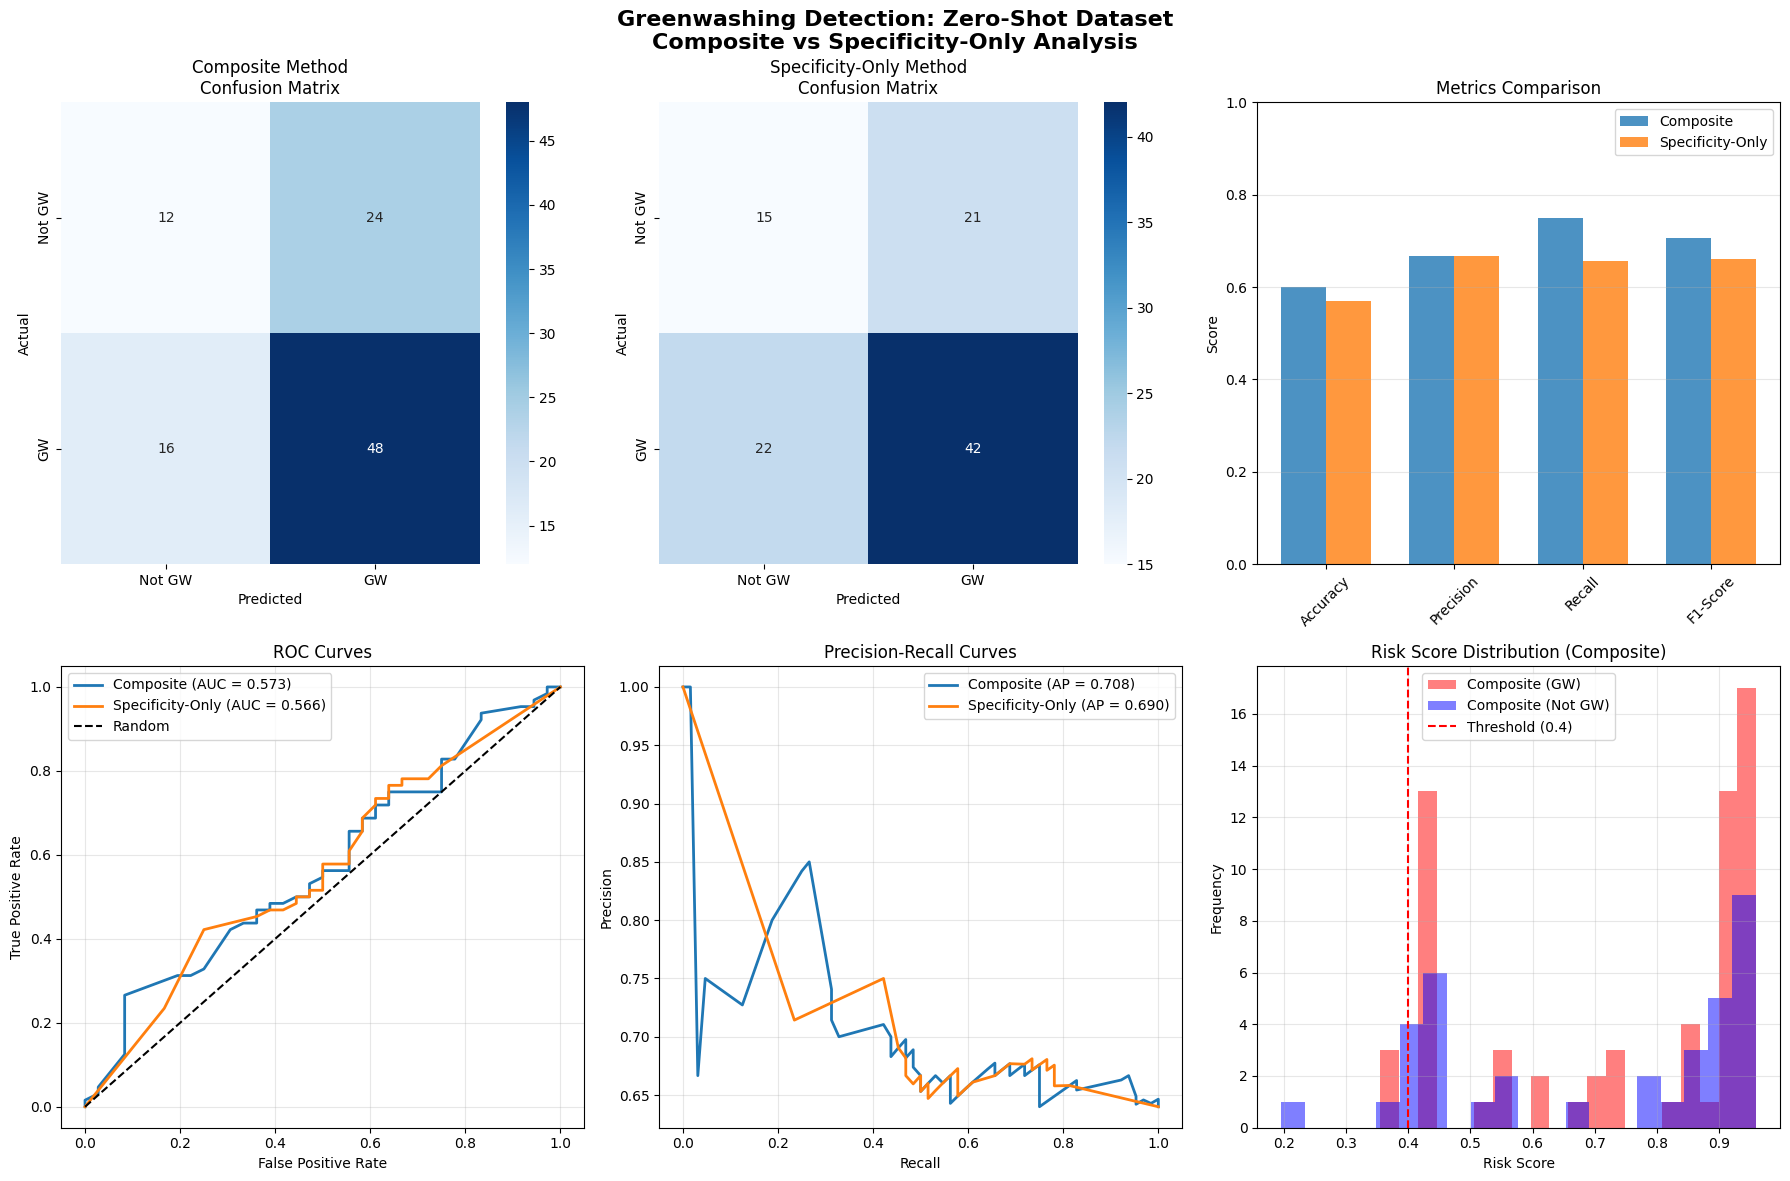


✓ Visualization saved as '../data/benchmark/zero_shot_full_evaluation.png'
✓ Specific confusion matrix saved to: ../image/comparison/zero-shot_cm.png

ADDITIONAL INSIGHTS

Disagreement cases: 9 out of 100 (9.0%)

Disagreement breakdown:
pred_composite  pred_specificity_only  greenwashing    
greenwashing    not_greenwashing       greenwashing        6
                                       not_greenwashing    3
dtype: int64

ROC AUC Scores:
  Composite:        0.5727
  Specificity-Only: 0.5658
  Difference:       +0.0069

Average Precision Scores:
  Composite:        0.7082
  Specificity-Only: 0.6899
  Difference:       +0.0183

✓ Detailed results saved to '../data/benchmark/zero_shot_results.csv'
Loading data from ../data/benchmark/greenwashing_one_shot.csv...
Total samples: 100
Clean samples (excluding errors/uncertain): 100

Label distribution:
greenwashing
greenwashing        60
not_greenwashing    40
Name: count, dtype: int64

Running predictions...
Processed 20/100 samples...
Pr

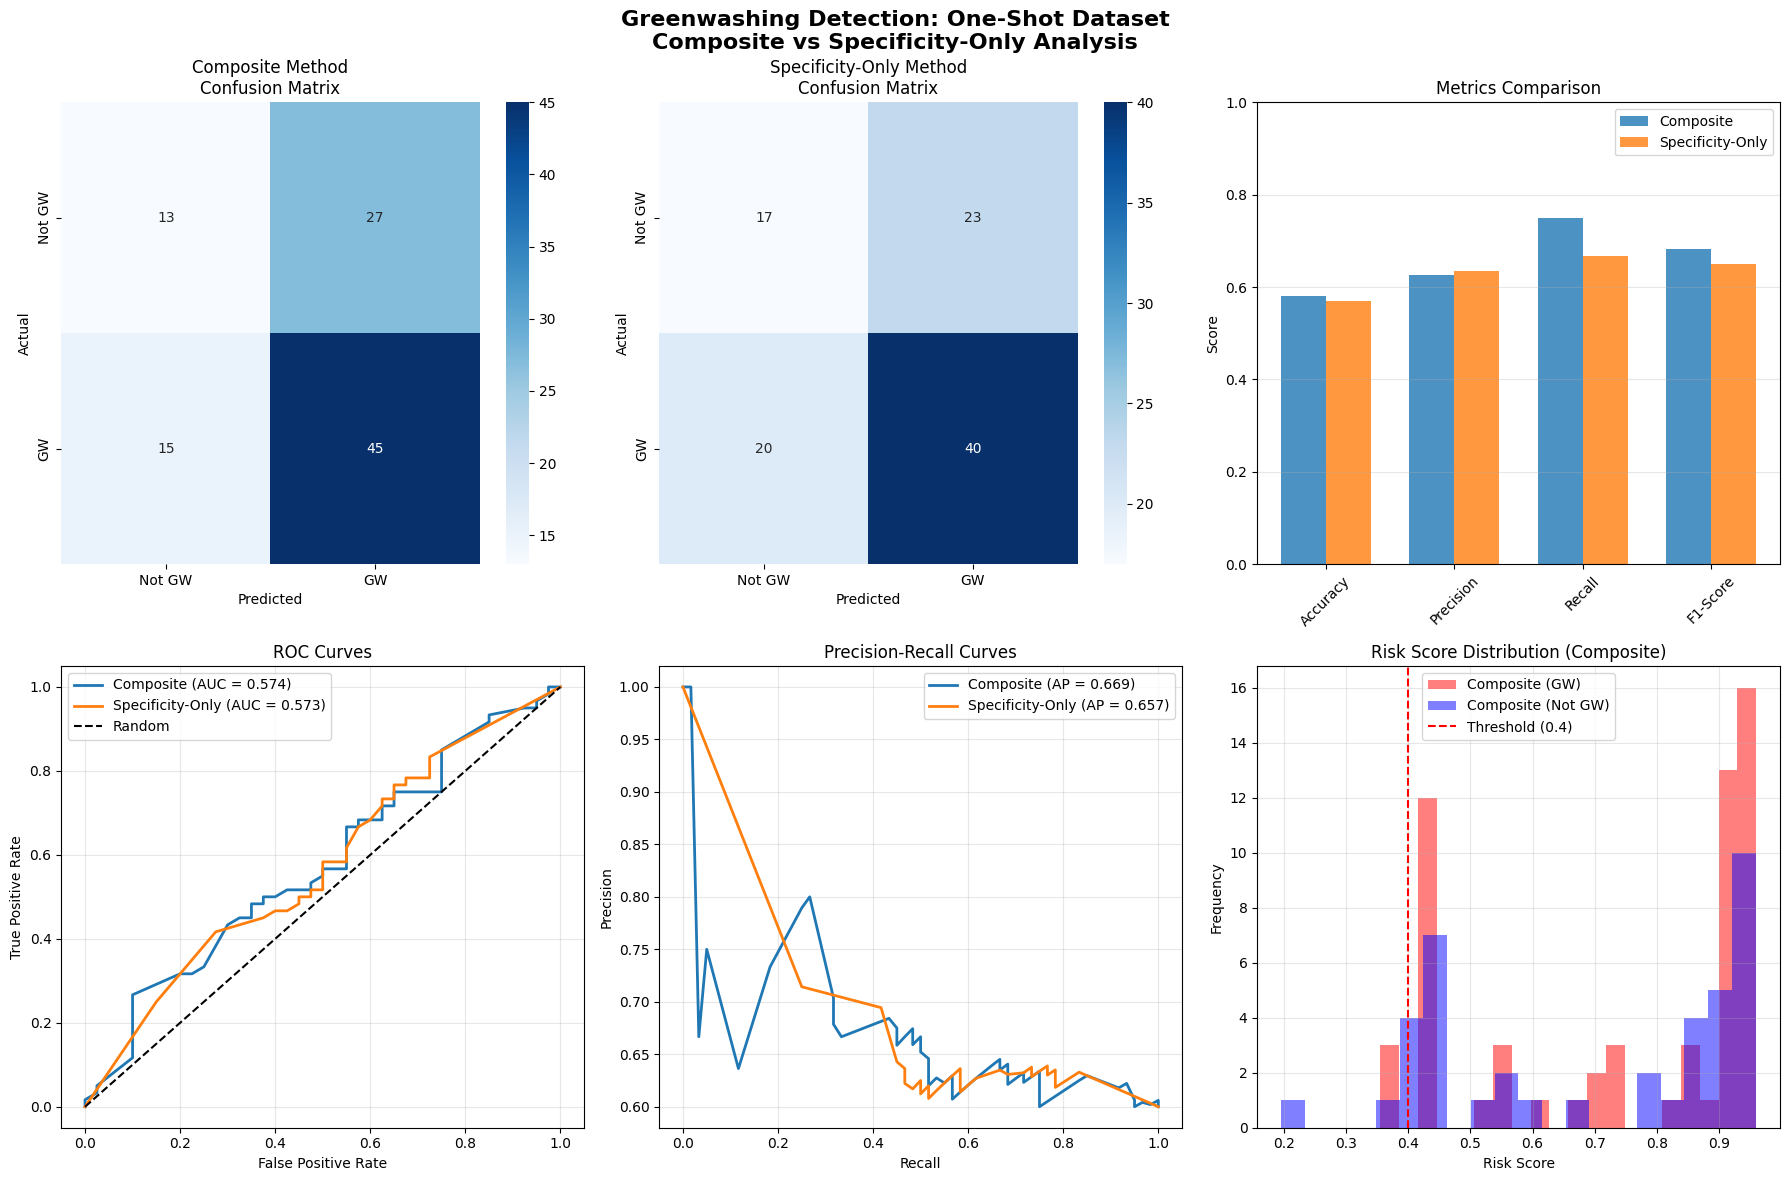


✓ Visualization saved as '../data/benchmark/one_shot_full_evaluation.png'
✓ Specific confusion matrix saved to: ../image/comparison/one-shot_cm.png

ADDITIONAL INSIGHTS

Disagreement cases: 9 out of 100 (9.0%)

Disagreement breakdown:
pred_composite  pred_specificity_only  greenwashing    
greenwashing    not_greenwashing       greenwashing        5
                                       not_greenwashing    4
dtype: int64

ROC AUC Scores:
  Composite:        0.5744
  Specificity-Only: 0.5725
  Difference:       +0.0019

Average Precision Scores:
  Composite:        0.6693
  Specificity-Only: 0.6574
  Difference:       +0.0119

✓ Detailed results saved to '../data/benchmark/one_shot_results.csv'
Loading data from ../data/benchmark/greenwashing_chain_of_thought.csv...
Total samples: 100
Clean samples (excluding errors/uncertain): 99

Label distribution:
greenwashing
greenwashing        69
not_greenwashing    30
Name: count, dtype: int64

Running predictions...
Processed 20/99 samples...

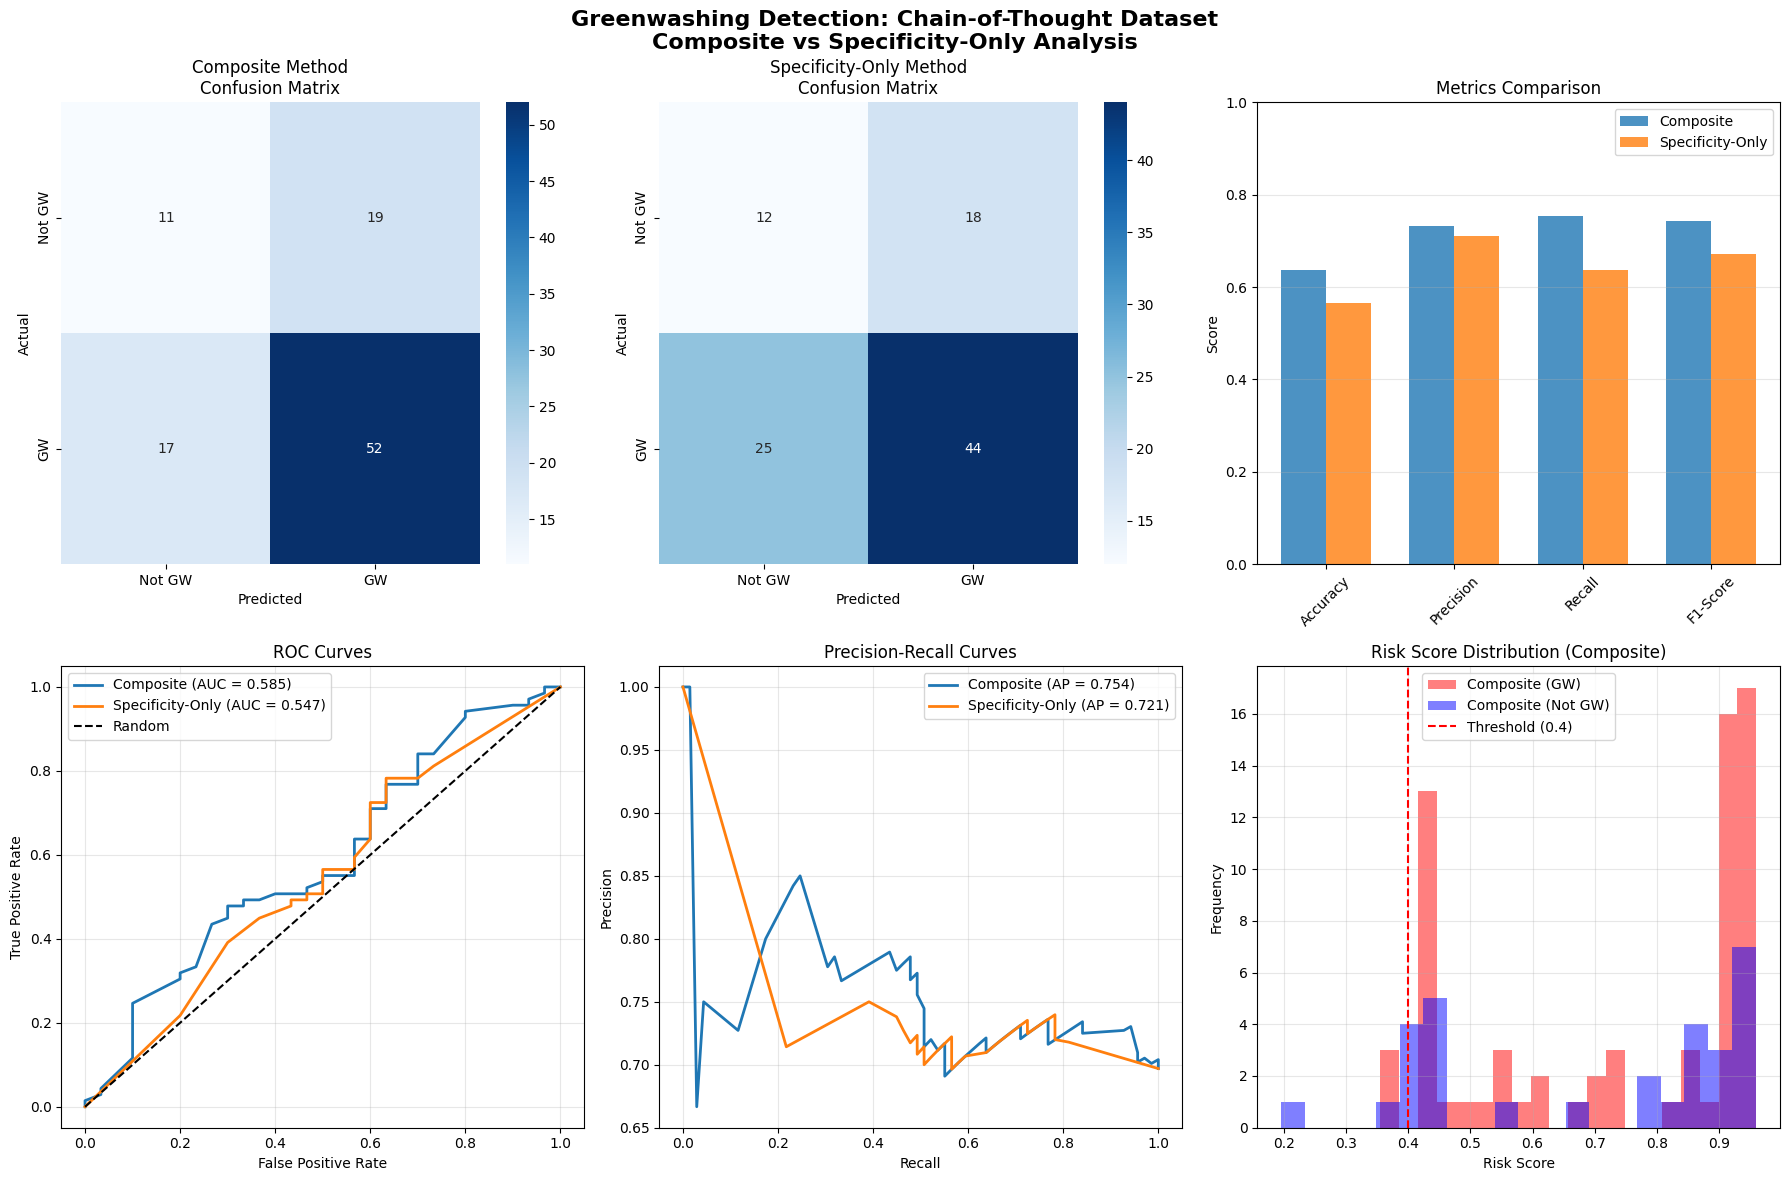


✓ Visualization saved as '../data/benchmark/chain_of_thought_full_evaluation.png'
✓ Specific confusion matrix saved to: ../image/comparison/chain-of-thought_cm.png

ADDITIONAL INSIGHTS

Disagreement cases: 9 out of 99 (9.1%)

Disagreement breakdown:
pred_composite  pred_specificity_only  greenwashing    
greenwashing    not_greenwashing       greenwashing        8
                                       not_greenwashing    1
dtype: int64

ROC AUC Scores:
  Composite:        0.5850
  Specificity-Only: 0.5471
  Difference:       +0.0379

Average Precision Scores:
  Composite:        0.7543
  Specificity-Only: 0.7210
  Difference:       +0.0333

✓ Detailed results saved to '../data/benchmark/chain_of_thought_results.csv'


In [27]:
# ============================================================================
# EXECUTION SECTION (No changes needed here, calls updated pipeline)
# ============================================================================

analyzer = GreenwashingAnalyzer(specificity_model_path='../models/specificity')

datasets_to_evaluate = [
    {
        'csv_path': '../data/benchmark/greenwashing_zero_shot.csv',
        'output_prefix': '../data/benchmark/zero_shot',
        'dataset_name': 'Zero-Shot Dataset'
    },
    {
        'csv_path': '../data/benchmark/greenwashing_one_shot.csv',
        'output_prefix': '../data/benchmark/one_shot',
        'dataset_name': 'One-Shot Dataset'
    },
    {
        'csv_path': '../data/benchmark/greenwashing_chain_of_thought.csv',
        'output_prefix': '../data/benchmark/chain_of_thought',
        'dataset_name': 'Chain-of-Thought Dataset'
    }
]

all_results = {}

for dataset_config in datasets_to_evaluate:
    results = run_full_evaluation(
        csv_path=dataset_config['csv_path'],
        analyzer=analyzer,
        output_prefix=dataset_config['output_prefix'],
        dataset_name=dataset_config['dataset_name']
    )
    all_results[dataset_config['dataset_name']] = results

In [28]:
## Comparison

In [29]:
# ============================================================================
# CROSS-DATASET COMPARISON
# ============================================================================

print(f"\n\n{'='*70}")
print("CROSS-DATASET SUMMARY")
print(f"{'='*70}\n")

summary_data = []
for dataset_name, results in all_results.items():
    summary_data.append({
        'Dataset': dataset_name,
        'Composite Accuracy': results['metrics_composite']['accuracy'],
        'Specificity Accuracy': results['metrics_specificity']['accuracy'],
        'Composite F1': results['metrics_composite']['f1'],
        'Specificity F1': results['metrics_specificity']['f1'],
        'Composite ROC AUC': results['roc_auc']['composite'],
        'Specificity ROC AUC': results['roc_auc']['specificity']
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Save cross-dataset summary
summary_df.to_csv('../data/benchmark/cross_dataset_summary.csv', index=False)
print(f"\n✓ Cross-dataset summary saved to 'data/benchmark/cross_dataset_summary.csv'")

print("\n" + "="*70)
print("ALL EVALUATIONS COMPLETE")
print("="*70)



CROSS-DATASET SUMMARY

                 Dataset  Composite Accuracy  Specificity Accuracy  Composite F1  Specificity F1  Composite ROC AUC  Specificity ROC AUC
       Zero-Shot Dataset            0.600000              0.570000      0.705882        0.661417           0.572700             0.565755
        One-Shot Dataset            0.580000              0.570000      0.681818        0.650407           0.574375             0.572500
Chain-of-Thought Dataset            0.636364              0.565657      0.742857        0.671756           0.585024             0.547101

✓ Cross-dataset summary saved to 'data/benchmark/cross_dataset_summary.csv'

ALL EVALUATIONS COMPLETE
